In [1]:
# !pip install opendatasets --quiet

# import opendatasets as od

# od.download('https://www.kaggle.com/datasets/hearfool/vggface2')

In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
path_data = '/kaggle/input/vggface2'

In [4]:
def generate_vggface_df(dir):
  image_path = []
  image_label = []
  for folder in os.listdir(dir):
      for label in os.listdir(dir + "/" + folder):
          for image in os.listdir(dir + "/" + folder + "/" + label):
              curr_path = dir + "/" + folder + "/" + label + "/" + image
              image_path.append(curr_path)
              image_label.append(label)

  return pd.DataFrame(zip(image_path, image_label), columns = ['image_path', 'label'])

In [5]:
train_df = generate_vggface_df(path_data)
# val_df = generate_vggface_df(path_val)

In [6]:
len(train_df)

197693

In [7]:
class_idx = {}
for i, label in enumerate(sorted(train_df['label'].unique())):
    class_idx[label] = i

In [8]:
train_df['label_'] = train_df['label'].map(class_idx)

In [9]:
train_df.to_csv("vggfave_train.csv")
# val_df.to_csv("vggfave_val.csv")

In [10]:
train_df.sample(5)

,image_path,label,label_
91229,/kaggle/input/vggface2/train/n000089/0013_02.jpg,n000089,88
176580,/kaggle/input/vggface2/train/n000165/0201_01.jpg,n000165,162
131695,/kaggle/input/vggface2/train/n000350/0258_01.jpg,n000350,346
21527,/kaggle/input/vggface2/train/n000232/0047_02.jpg,n000232,228
118518,/kaggle/input/vggface2/train/n000355/0068_01.jpg,n000355,351


In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.12, stratify=train_df['label_'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.4, stratify=val_df['label_'], random_state=42)

In [12]:
val_df.sample(5)

,image_path,label,label_
185059,/kaggle/input/vggface2/train/n000183/0214_01.jpg,n000183,180
114866,/kaggle/input/vggface2/train/n000015/0225_01.jpg,n000015,14
111164,/kaggle/input/vggface2/train/n000418/0088_01.jpg,n000418,413
51478,/kaggle/input/vggface2/train/n000116/0763_01.jpg,n000116,115
17093,/kaggle/input/vggface2/val/n001291/0567_01.jpg,n001291,537


In [13]:
test_df.sample(5)

,image_path,label,label_
39629,/kaggle/input/vggface2/train/n000264/0429_02.jpg,n000264,260
34253,/kaggle/input/vggface2/train/n000415/0158_01.jpg,n000415,410
146223,/kaggle/input/vggface2/train/n000173/0069_01.jpg,n000173,170
2470,/kaggle/input/vggface2/val/n000746/0040_01.jpg,n000746,509
23780,/kaggle/input/vggface2/train/n000033/0304_03.jpg,n000033,32


In [14]:
len(train_df), len(val_df), len(test_df)

(173969, 14234, 9490)

<Axes: ylabel='Frequency'>

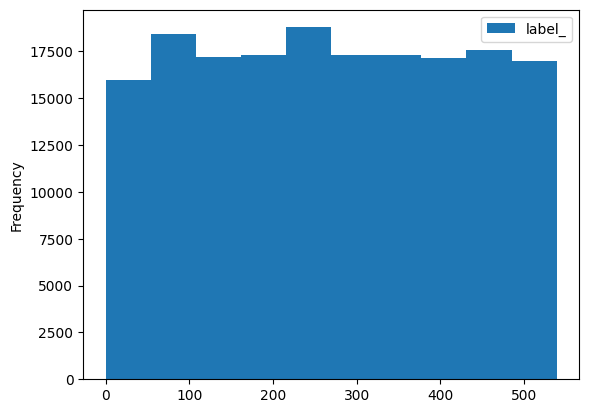

In [15]:
train_df.plot(kind='hist')

In [16]:
path_sample = val_df.sample(1).iloc[0]
print(path_sample)

image_path    /kaggle/input/vggface2/train/n000282/0594_01.jpg
label                                                  n000282
label_                                                     278
Name: 92058, dtype: object


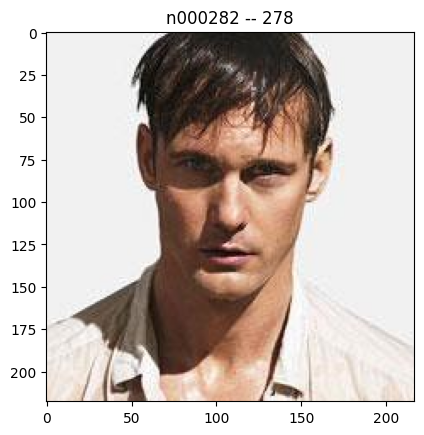

In [17]:
image = cv2.imread(path_sample['image_path'])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title(f"{path_sample['label']} -- {path_sample['label_']}")
plt.imshow(image_rgb)
plt.show()

In [18]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import datetime as dt
from sklearn.metrics import accuracy_score
import kagglehub

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
def resize_image(image, dsize=(224, 224)):
    resized_image = cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [20]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [21]:
class customDatasets(Dataset):
  def __init__(self, dataframe, transform=None):
     super().__init__()
     self.dataframe = dataframe
     self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index, 0]
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Image not found or unreadable at path: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_resized = resize_image(image)

    label = torch.tensor(int(self.dataframe.iloc[index, 2]), dtype=torch.long)

    if self.transform:
        image_resized = self.transform(image_resized)

    return image_resized, label


In [22]:
train_dataset = customDatasets(train_df, transform=transformer)
test_dataset = customDatasets(test_df, transform=transformer)
val_dataset = customDatasets(val_df, transform=transformer)

In [23]:
BATCH_SIZE = 128

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

(224, 224, 3)


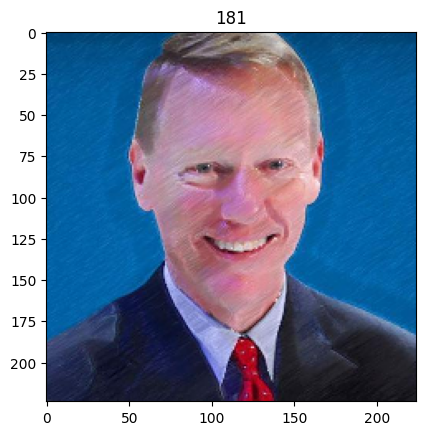

In [25]:
images, labels = next(iter(train_dataloader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

for i in range(len(images)):
    image = images[i].transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)

    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.show()
    break

In [26]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.pointwise(self.depthwise(x))))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv(channels, channels)
        self.conv2 = DepthwiseSeparableConv(channels, channels)
    
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

class EfficientFRBackbone(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Downsample
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.stage1 = nn.Sequential(
            DepthwiseSeparableConv(32, 64),
            ResidualBlock(64),
            nn.MaxPool2d(2)
        )

        self.stage2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128),
            ResidualBlock(128),
            nn.MaxPool2d(2)
        )

        self.stage3 = nn.Sequential(
            DepthwiseSeparableConv(128, 256),
            ResidualBlock(256),
            nn.MaxPool2d(2)
        )

        self.stage4 = nn.Sequential(
            DepthwiseSeparableConv(256, 512),
            ResidualBlock(512),
            nn.AdaptiveAvgPool2d((1, 1))  # Global pooling
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.embedding(x)
        return x

In [27]:
class ArcFace(nn.Module):
    def __init__(self, in_features, num_classes, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        nn.init.xavier_uniform_(self.weight)
        
    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        W = F.normalize(self.weight)
        
        # Cosine similarity
        cos_theta = torch.matmul(embeddings, W.t()).clamp(-1, 1)
        
        # Apply angular margin
        theta = torch.acos(cos_theta)
        cos_theta_m = torch.cos(theta + self.m)
        
        # One-hot encoding
        one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # Apply margin to correct class
        logits = self.s * (one_hot * cos_theta_m + (1 - one_hot) * cos_theta)
        return logits

In [28]:
class FaceNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=512):
        super().__init__()
        self.backbone = EfficientFRBackbone(embedding_dim)
        self.arcface = ArcFace(embedding_dim, num_classes)
        
    def forward(self, x, labels=None):
        embeddings = self.backbone(x)
        if labels is not None:
            return self.arcface(embeddings, labels)
        return embeddings

In [29]:
num_classes = len(train_df['label'].unique())
num_class2 = len(val_df['label'].unique())
num_class3 = len(test_df['label'].unique())
print(num_classes, num_class2, num_class3)

540 540 540


In [30]:
train_files = set(train_df['image_path'])
val_files = set(val_df['image_path'])
print(f"Overlapping files: {len(train_files & val_files)}")

Overlapping files: 0


In [31]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
# print(f"Model initialized on {device}")

In [32]:
# model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
# # state_dict = torch.load("/kaggle/input/arfcace_v1/pytorch/default/1/arcface_model(1).pth")
# # model.load_state_dict(state_dict)
# # print(f"Model initialized on {device}")

In [33]:
resume = True

In [34]:
model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)

In [35]:
EPOCHS = 22
learning_rate = 1e-3
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
checkpoint_dir = '/kaggle/input/v2/pytorch/default/1/'
checkpoint_pattern = os.path.join(checkpoint_dir, "arcface_model_artifact_19")


if resume:
    checkpoints = sorted(glob.glob(checkpoint_pattern), key=os.path.getmtime)
    if checkpoints:
        resume_checkpoint = checkpoints[-1]
        print(f"Resuming from checkpoint: {resume_checkpoint}")
        checkpoint = torch.load(resume_checkpoint, map_location=device)

        model.load_state_dict(torch.load('/kaggle/input/v2/pytorch/default/1/arcface_model_final_23.pth'))
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history = checkpoint['history']
        start_epoch = checkpoint['epoch']
    else:
        print("No checkpoint found. Starting from scratch.")

Resuming from checkpoint: /kaggle/input/v2/pytorch/default/1/arcface_model_artifact_19


In [37]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
            Conv2d-5         [-1, 64, 112, 112]           2,048
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-8         [-1, 64, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]             576
           Conv2d-10         [-1, 64, 112, 112]           4,096
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-13         [-1, 64, 112, 112]               0
           Conv2d-14         [

In [38]:
print("Starting training...")
history = {
    'train_loss': [], 'dev_loss': [],
    'train_acc': [], 'dev_acc': [],
    'lr': []
}

start_time = dt.datetime.now()

for epoch in range(EPOCHS):
    # === Training phase ===
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    # === Validation phase ===
    model.eval()
    epoch_dev_loss = 0
    dev_correct = 0
    dev_total = 0

    with torch.no_grad():
        dev_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in dev_loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            epoch_dev_loss += loss.item()

            preds = torch.argmax(outputs, 1)
            dev_correct += (preds == labels).sum().item()
            dev_total += labels.size(0)

            dev_loop.set_postfix(val_loss=loss.item())

    # === Calculate metrics ===
    train_loss = epoch_train_loss / len(train_dataloader)
    dev_loss = epoch_dev_loss / len(val_dataloader)
    train_acc = train_correct / train_total
    dev_acc = dev_correct / dev_total
    current_lr = optimizer.param_groups[0]['lr']

    # === Update history ===
    history['train_loss'].append(train_loss)
    history['dev_loss'].append(dev_loss)
    history['train_acc'].append(train_acc)
    history['dev_acc'].append(dev_acc)
    history['lr'].append(current_lr)

    # Update scheduler
    scheduler.step(dev_acc)

    # === Print epoch summary ===
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {dev_loss:.4f} | Acc: {dev_acc:.4f}")
    print(f"Current Learning Rate: {current_lr:.6f}")
    print("-" * 60)

    # === Save checkpoint every 10 epochs ===
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'arcface_model_artifact_{epoch}')

# Training completion
end_time = dt.datetime.now()
print(f"Training completed in: {end_time - start_time}")
torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'arcface_model_artifact_{EPOCHS + 20}')

Starting training...


Epoch 1/22 [Val]: 100%|██████████| 112/112 [03:23<00:00,  1.81s/it, val_loss=4.89]



Epoch 1/22 Summary:
Train Loss: 1.5938 | Acc: 0.7062
Val   Loss: 5.0311 | Acc: 0.4490
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 2/22 [Val]: 100%|██████████| 112/112 [01:18<00:00,  1.43it/s, val_loss=7.31]



Epoch 2/22 Summary:
Train Loss: 1.5527 | Acc: 0.7093
Val   Loss: 5.1521 | Acc: 0.4401
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 3/22 [Val]: 100%|██████████| 112/112 [01:17<00:00,  1.44it/s, val_loss=2.39]



Epoch 3/22 Summary:
Train Loss: 1.4832 | Acc: 0.7184
Val   Loss: 4.8726 | Acc: 0.4630
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 4/22 [Val]: 100%|██████████| 112/112 [01:16<00:00,  1.46it/s, val_loss=6.57]



Epoch 4/22 Summary:
Train Loss: 1.4259 | Acc: 0.7249
Val   Loss: 5.2919 | Acc: 0.4257
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 5/22 [Val]: 100%|██████████| 112/112 [01:19<00:00,  1.40it/s, val_loss=4.93]



Epoch 5/22 Summary:
Train Loss: 1.3599 | Acc: 0.7342
Val   Loss: 4.9250 | Acc: 0.4612
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 6/22 [Val]: 100%|██████████| 112/112 [01:15<00:00,  1.49it/s, val_loss=5.96]



Epoch 6/22 Summary:
Train Loss: 1.2851 | Acc: 0.7454
Val   Loss: 4.8518 | Acc: 0.4761
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 7/22 [Val]: 100%|██████████| 112/112 [01:20<00:00,  1.40it/s, val_loss=7.11]



Epoch 7/22 Summary:
Train Loss: 1.2323 | Acc: 0.7532
Val   Loss: 4.9743 | Acc: 0.4620
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 8/22 [Val]: 100%|██████████| 112/112 [01:17<00:00,  1.45it/s, val_loss=4.48]



Epoch 8/22 Summary:
Train Loss: 1.1737 | Acc: 0.7613
Val   Loss: 4.7960 | Acc: 0.4845
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 9/22 [Val]: 100%|██████████| 112/112 [01:18<00:00,  1.44it/s, val_loss=6.61]



Epoch 9/22 Summary:
Train Loss: 1.1250 | Acc: 0.7683
Val   Loss: 4.9395 | Acc: 0.4681
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 10/22 [Val]: 100%|██████████| 112/112 [01:31<00:00,  1.22it/s, val_loss=5.15]



Epoch 10/22 Summary:
Train Loss: 1.0697 | Acc: 0.7775
Val   Loss: 4.9723 | Acc: 0.4677
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 11/22 [Val]: 100%|██████████| 112/112 [01:30<00:00,  1.23it/s, val_loss=6.44]



Epoch 11/22 Summary:
Train Loss: 1.0198 | Acc: 0.7855
Val   Loss: 4.8318 | Acc: 0.4827
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 12/22 [Val]: 100%|██████████| 112/112 [01:23<00:00,  1.35it/s, val_loss=5.56]



Epoch 12/22 Summary:
Train Loss: 0.5311 | Acc: 0.8939
Val   Loss: 4.3007 | Acc: 0.5344
Current Learning Rate: 0.000500
------------------------------------------------------------


Epoch 13/22 [Val]: 100%|██████████| 112/112 [01:22<00:00,  1.35it/s, val_loss=5.47]



Epoch 13/22 Summary:
Train Loss: 0.4286 | Acc: 0.9177
Val   Loss: 4.4459 | Acc: 0.5227
Current Learning Rate: 0.000500
------------------------------------------------------------


Epoch 14/22 [Val]: 100%|██████████| 112/112 [01:21<00:00,  1.37it/s, val_loss=3.6]



Epoch 14/22 Summary:
Train Loss: 0.4092 | Acc: 0.9193
Val   Loss: 4.3757 | Acc: 0.5313
Current Learning Rate: 0.000500
------------------------------------------------------------


Epoch 15/22 [Val]: 100%|██████████| 112/112 [01:26<00:00,  1.29it/s, val_loss=5.74]



Epoch 15/22 Summary:
Train Loss: 0.3791 | Acc: 0.9251
Val   Loss: 4.4320 | Acc: 0.5273
Current Learning Rate: 0.000500
------------------------------------------------------------


Epoch 16/22 [Val]: 100%|██████████| 112/112 [01:20<00:00,  1.39it/s, val_loss=5.84]



Epoch 16/22 Summary:
Train Loss: 0.2093 | Acc: 0.9718
Val   Loss: 4.2486 | Acc: 0.5503
Current Learning Rate: 0.000250
------------------------------------------------------------


Epoch 17/22 [Val]: 100%|██████████| 112/112 [01:22<00:00,  1.35it/s, val_loss=3.89]



Epoch 17/22 Summary:
Train Loss: 0.1728 | Acc: 0.9814
Val   Loss: 4.2332 | Acc: 0.5506
Current Learning Rate: 0.000250
------------------------------------------------------------


Epoch 18/22 [Val]: 100%|██████████| 112/112 [01:27<00:00,  1.27it/s, val_loss=3.87]



Epoch 18/22 Summary:
Train Loss: 0.1663 | Acc: 0.9829
Val   Loss: 4.2958 | Acc: 0.5450
Current Learning Rate: 0.000250
------------------------------------------------------------


Epoch 19/22 [Val]: 100%|██████████| 112/112 [01:26<00:00,  1.30it/s, val_loss=3.63]



Epoch 19/22 Summary:
Train Loss: 0.1545 | Acc: 0.9850
Val   Loss: 4.2469 | Acc: 0.5502
Current Learning Rate: 0.000250
------------------------------------------------------------


Epoch 20/22 [Val]: 100%|██████████| 112/112 [01:28<00:00,  1.27it/s, val_loss=2.95]



Epoch 20/22 Summary:
Train Loss: 0.1454 | Acc: 0.9865
Val   Loss: 4.2802 | Acc: 0.5472
Current Learning Rate: 0.000250
------------------------------------------------------------


Epoch 21/22 [Val]: 100%|██████████| 112/112 [01:32<00:00,  1.21it/s, val_loss=6.32]



Epoch 21/22 Summary:
Train Loss: 0.0969 | Acc: 0.9954
Val   Loss: 4.1902 | Acc: 0.5598
Current Learning Rate: 0.000125
------------------------------------------------------------


Epoch 22/22 [Val]: 100%|██████████| 112/112 [01:25<00:00,  1.30it/s, val_loss=4.01]


Epoch 22/22 Summary:
Train Loss: 0.0859 | Acc: 0.9969
Val   Loss: 4.1945 | Acc: 0.5598
Current Learning Rate: 0.000125
------------------------------------------------------------
Training completed in: 8:57:54.620504


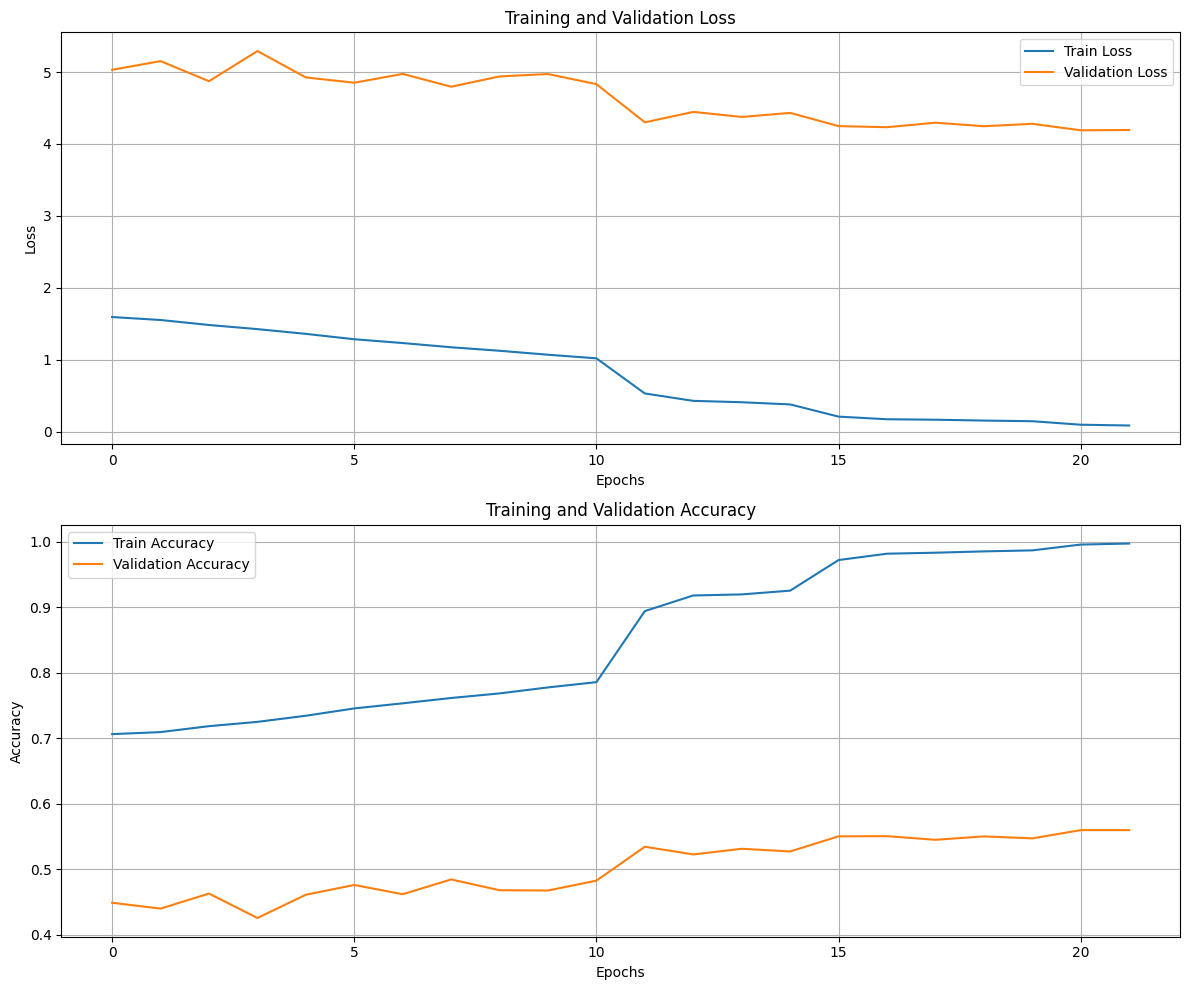

In [39]:
# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['dev_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['dev_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()